In [1]:
import numpy as np
from climada.hazard import TCTracks
import warnings # To hide the warnings
warnings.filterwarnings('ignore')

/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
tracks = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA') # Here we download the full dataset for the analysis
# afterwards (e.g. return period), but you can also use "year_range" to adjust the range of the dataset to be downloaded.
# While doing that, you need to make sure that the year 2017 is included if you want to run the blocks with the codes
# subsetting a specific tropic cyclone, which happened in 2017. (Of course, you can also change the subsetting codes.)

2024-07-11 18:44:56,590 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ming/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-11 18:44:59,138 - climada.hazard.tc_tracks - WARNING - 1118 storm events are discarded because no valid wind/pressure values have been found: 1851175N26270, 1851181N19275, 1851187N22262, 1851192N12300, 1851214N14321, ...
2024-07-11 18:44:59,149 - climada.hazard.tc_tracks - WARNING - 140 storm events are discarded because only one valid timestep has been found: 1852232N21293, 1853242N12336, 1855236N12304, 1856221N25277, 1856235N13302, ...


2024-07-11 18:45:16,014 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ming/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


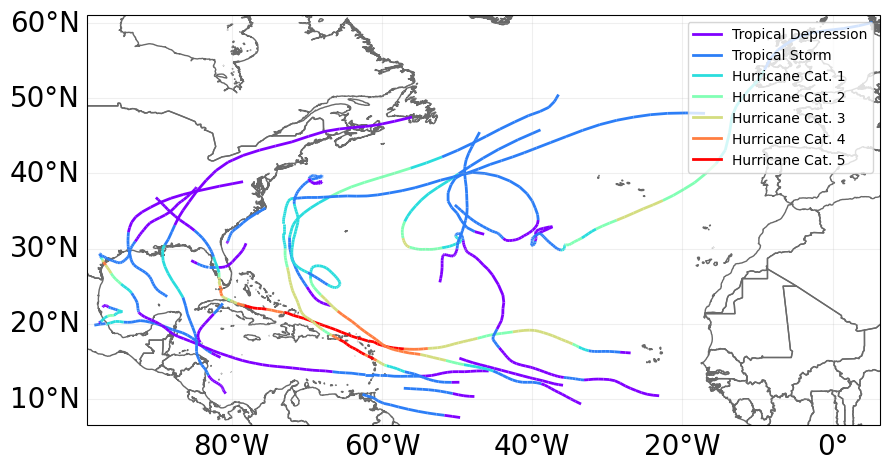

In [3]:
# plotting tracks can be very time consuming, depending on the number of tracks. So we choose only a few here, by limiting the time range to one year
tracks_2017 = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA', year_range = (2017, 2017))
tracks_2017 .plot(); # This may take a very long time


In [ ]:
tracks.equal_timestep()

In [ ]:
tracks.equal_timestep(time_step_h=0.5)

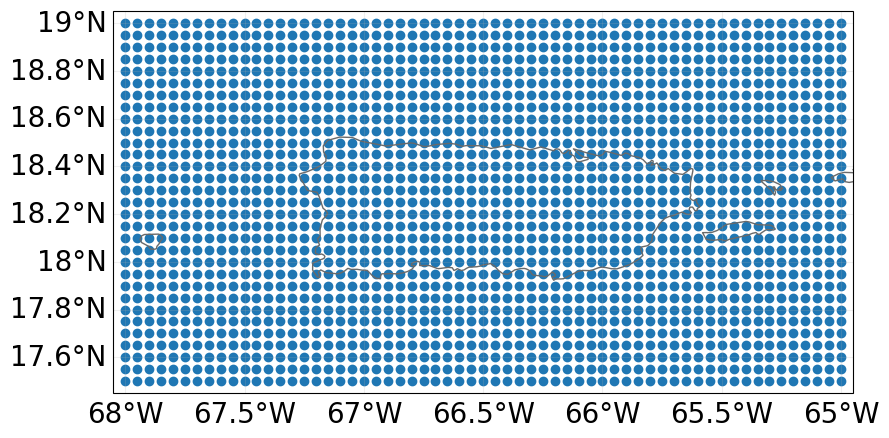

In [4]:
from climada.hazard import Centroids

min_lat, max_lat, min_lon, max_lon = 17.5, 19.0, -68.0, -65.0
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.05)
cent.check()
cent.plot();

In [ ]:
tracks

In [5]:
from climada.hazard import TropCyclone

haz = TropCyclone.from_tracks(tracks, centroids=cent)
haz.check()

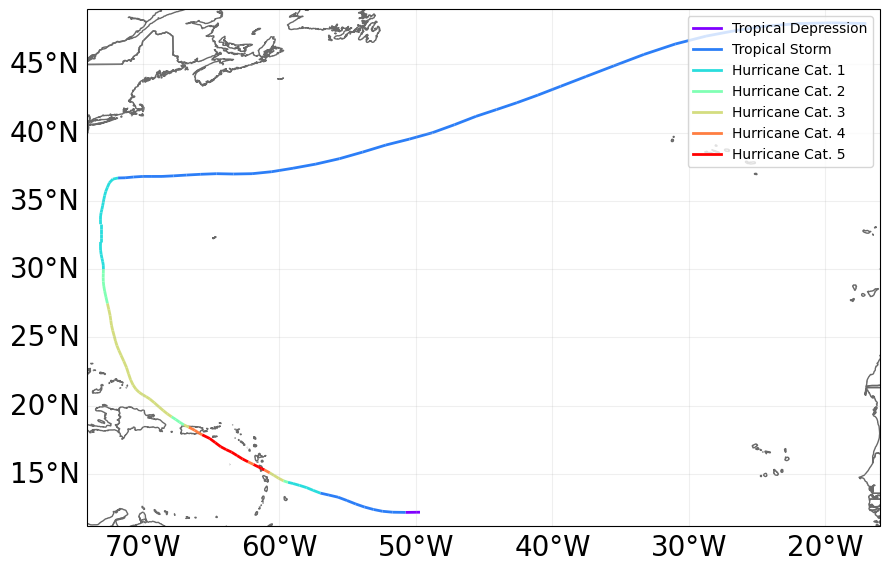

In [6]:
tracks.subset({"sid": "2017260N12310"}).plot();  # This is how we subset a TCTracks object


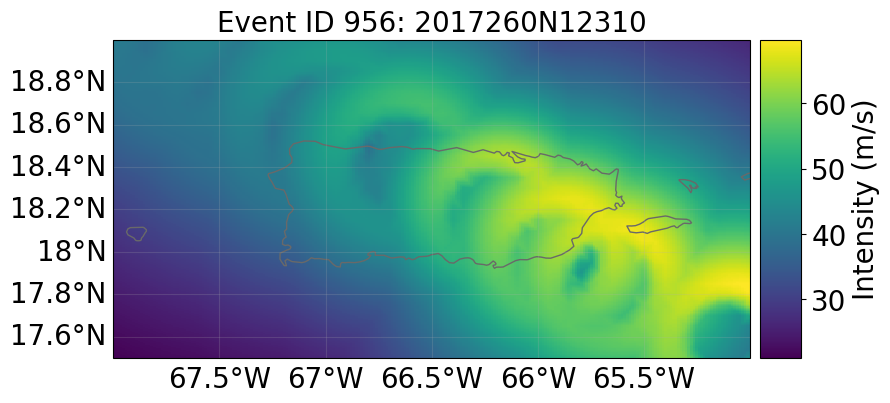

In [7]:
haz.plot_intensity(event='2017260N12310');

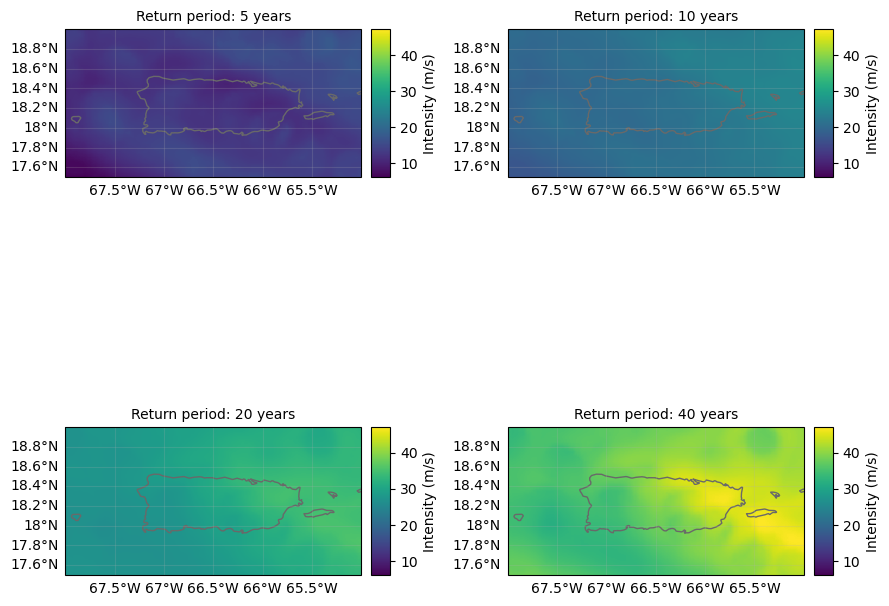

In [8]:
haz.plot_rp_intensity(return_periods=(5,10,20,40));

In [9]:
from climada.entity.exposures import LitPop

exp_litpop = LitPop.from_countries('Puerto Rico', res_arcsec = 120)  # We'll go lower resolution than default to keep it simple
exp_litpop.set_geometry_points() # Set geodataframe geometries from lat lon data

exp_litpop.plot_hexbin(pop_name=True, linewidth=4, buffer=0.1);

FileNotFoundError: The file /home/ming/climada/data/gpw-v4-population-count-rev11_2020_30_sec_tif/gpw_v4_population_count_rev11_2020_30_sec.tif could not be found. Please download the file first or choose a different folder. The data can be downloaded from http://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse, e.g., http://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-count-rev11/gpw-v4-population-count-rev11_2020_30_sec_tif.zip (Free NASA Earthdata login required).

In [ ]:
from climada.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone

imp_fun = ImpfTropCyclone.from_emanuel_usa()
imp_fun.plot();

In [ ]:
imp_fun_set = ImpactFuncSet([imp_fun])

In [ ]:
exp_litpop.gdf['impf_TC'] = 1

In [ ]:
from climada.entity import Measure, MeasureSet

meas_mangrove = Measure(
    name='Mangrove',
    haz_type='TC',
    color_rgb=np.array([0.2, 0.2, 0.7]),
    cost=500000000,
    mdd_impact=(1, 0),
    paa_impact=(1, -0.15),
    hazard_inten_imp=(1, -10),
)

meas_set = MeasureSet(measure_list=[meas_mangrove])
meas_set.check()


In [ ]:
mangrove_exp, mangrove_imp_fun_set, mangrove_haz = meas_mangrove.apply(exp_litpop, imp_fun_set, haz)
axes1 = imp_fun_set.plot()
axes1.set_title('TC: Emanuel (2011) impact function')
axes2 = mangrove_imp_fun_set.plot()
axes2.set_title('TC: Modified impact function')

In [ ]:
meas_buildings = Measure(
    name='Building code',
    haz_type='TC',
    color_rgb=np.array([0.2, 0.7, 0.5]),
    cost=100000000,
    hazard_freq_cutoff=0.1,
)

meas_set.append(meas_buildings)
meas_set.check()

buildings_exp, buildings_imp_fun_set, buildings_haz = meas_buildings.apply(exp_litpop, imp_fun_set, haz)



In [ ]:
haz.plot_rp_intensity(return_periods=(5, 20));
buildings_haz.plot_rp_intensity(return_periods=(5, 20));

In [ ]:
from climada.entity import DiscRates

years=np.arange(1950, 2101)
rates=np.ones(years.size) * 0.02
disc = DiscRates(years=years, rates=rates)
disc.check()
disc.plot()

In [ ]:
from climada.entity import Entity

ent = Entity(
    exposures=exp_litpop,
    disc_rates=disc,
    impact_func_set=imp_fun_set,
    measure_set=meas_set
)

In [ ]:
from climada.engine import ImpactCalc

imp = ImpactCalc(ent.exposures, ent.impact_funcs, haz).impact()


In [ ]:
freq_curve = imp.calc_freq_curve() # impact exceedance frequency curve
freq_curve.plot();

print('Expected average annual impact: {:.3e} USD'.format(imp.aai_agg))


In [ ]:
imp.plot_basemap_eai_exposure(buffer=0.1); # average annual impact at each exposure


In [ ]:
import os
from climada.util import save, load

### Uncomment this to save - saves by default to ./results/
# save('impact_puerto_rico_tc.p', imp)

### Uncomment this to read the saved data:
# abs_path = os.path.join(os.getcwd(), 'results/impact_puerto_rico_tc.p')
# data = load(abs_path)

In [ ]:
from climada.engine import CostBenefit

cost_ben = CostBenefit()
cost_ben.calc(haz, ent, future_year=2040) # prints costs and benefits
cost_ben.plot_cost_benefit(); # plot cost benefit ratio and averted damage of every exposure
cost_ben.plot_event_view(return_per=(10, 20, 40)); # plot averted damage of each measure for every return period
